# Random Forest Classifier

## Get dataset

In [2]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

In [3]:
import finlab.ml as ml

dataset = ml.fundamental_features()

print(dataset.shape)
dataset = dataset.dropna(thresh=int(len(dataset)*0.5), axis=1).dropna(how='any')
print(dataset.shape)

(69005, 48)
(33943, 48)


## Add labels

In [4]:
feature_names = list(dataset.columns)

In [5]:
ml.add_profit_prediction(dataset)
dataset.head()

T3395營業利益  T7210營運現金流  T3950歸屬母公司淨利    T7211折舊  \
stock_id date                                                         
1101     2014-05-15  3684224.0   6895832.0     4015175.0  1594505.0   
         2014-08-14  5938317.0   4452573.0     -754894.0  1573692.0   
         2014-11-14  5544164.0   3701961.0     3621052.0  1587492.0   
         2015-03-31  4690964.0   4936554.0     6459366.0  1575810.0   
         2015-05-15  1693508.0   5654152.0      349121.0  1711428.0   

                      T0100流動資產   T1100流動負債  T7324取得不動產廠房及設備  T3970經常稅後淨利  \
stock_id date                                                               
1101     2014-05-15  92121458.0  74388787.0        -940633.0    2791235.0   
         2014-08-14  89163129.0  81190613.0        -465009.0    4828695.0   
         2014-11-14  89472928.0  78920574.0        -911057.0    4934486.0   
         2015-03-31  96605816.0  68632044.0       -1384489.0    4029460.0   
         2015-05-15  92471096.0  69579858.0        -818460.0     974518.0   

                     R101_ROA稅後息前  R11V_ROA綜合損益  ...   R501_流動比率   R502_速動比率  \
stock_id date                                    ...                           
1101     2014-05-15     -1.732411      1.630076  ...  123.837828  101.776758   
         2014-08-14     -0.952778      0.152556  ...  109.819505   91.450337   
         2014-11-14     -0.948101      2.168353  ...  113.370853   93.976558   
         2015-03-31     -1.265106      3.002608  ...  140.759054  117.966121   
         2015-05-15     -2.315297      0.069454  ...  132.899231  109.303861   

                     R503_利息支出率   R678_營運資金  R607_總資產週轉次數  R610_存貨週轉率  \
stock_id date                                                           
1101     2014-05-15   -9.792979  17732671.0      0.093998    2.191306   
         2014-08-14  -17.435186   7972516.0      0.112552    2.381079   
         2014-11-14  -17.800651  10552354.0      0.106864    2.306032   
         2015-03-31  -13.169666  27973772.0      0.103034    2.268994   
         2015-05-15   -7.153186  22891238.0      0.073611    1.817298   

                     R612_固定資產週轉次數  R613_淨值週轉率次  R69B_自由現金流量    return  
stock_id date                                                           
1101     2014-05-15       0.245688     0.171327    4901868.0  1.073347  
         2014-08-14       0.297377     0.208493   16542181.0  0.984816  
         2014-11-14       0.282283     0.200028    4768224.0  0.969163  
         2015-03-31       0.275197     0.187942  -10525322.0  0.956818  
         2015-05-15       0.195713     0.132250    8494249.0  0.850077  

[5 rows x 49 columns]

## Split Train Test dataset

In [26]:
date_arr = dataset.index.get_level_values('date') < '2021'
dataset_train = dataset[date_arr]
dataset_test = dataset[~date_arr]

## Training

### RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier

cf = RandomForestClassifier(n_estimators=100)

train = dataset_train[feature_names] , dataset_train['return'] > 1
test = dataset_test[feature_names] , dataset_test['return'] > 1 

cf.fit(*train)
cf.score(*test)
cf.predict(test[0])

array([False, False, False, ..., False, False, False])

In [22]:
cf.score(*test)

0.5323187557488084

### Xgboost

In [23]:
import xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cf_xgb = xgboost.XGBClassifier()
cf_xgb.fit(*train)
cf_xgb.score(*test)

[09:12:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5211556150179781

#### 最佳化

In [14]:
import time 
from sklearn.model_selection import RandomizedSearchCV 
#x_train, y_train, x_valid, y_valid, x_test, y_test =  # load datasets 
cf_xgb = xgboost.XGBClassifier() 
param_grid = { 
        'silent': [False], 
        'max_depth': [6, 10, 15, 20], 
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3], 
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0], 
        'gamma': [0, 0.25, 0.5, 1.0], 
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0], 
        'n_estimators': [100]} 
fit_params = {#'eval_metric': 'mlogloss', 
              'early_stopping_rounds': 10, 
              'eval_set': [test], 
              'verbose': 0} 
rs = RandomizedSearchCV(cf_xgb, param_grid, n_iter=20, 
                            n_jobs=1, verbose=2, cv=2, 
                            scoring='neg_log_loss', refit=True, random_state=42) 

In [15]:
rs.fit(*train, **fit_params)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[09:00:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:00:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9, gamma=1.0, learning_rate=0.2, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, silent=False, subsample=0.7; total time=   0.2s
[09:00:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with som

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                       

In [12]:
#rs.best_estimator_
#rs.best_score_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=1.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=5.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=50.0, scale_pos_weight=1,
              silent=False, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

### lightgbm

In [ ]:
import lightgbm

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
     estimator=clf, param_distributions=param_test, 
     n_iter=n_HP_points_to_test,
     scoring='roc_auc',
     cv=3,
     refit=True,
     random_state=314,
     verbose=True)

In [ ]:
#沒有設參數的話，分數是多少
cf_lgbm_O = lightgbm.LGBMClassifier()

cf_lgbm_O.fit(dataset_train[feature_names],dataset_train['return'] > 1)
cf_lgbm_O.score(dataset_test[feature_names],dataset_test['return'] > 1)

In [ ]:
gs.fit(*train, **fit_params)

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_score_

In [ ]:

cf_lgbm = lightgbm.LGBMClassifier(colsample_bytree=0.7916310138090942, metric='None',
               min_child_samples=400, n_estimators=5000, n_jobs=4,
               num_leaves=11, random_state=314, reg_alpha=0.1, reg_lambda=20,
               subsample=0.2064253891443727)

cf_lgbm.fit(dataset_train[feature_names],dataset_train['return'] > 1, **fit_params)
cf_lgbm.score(dataset_test[feature_names],dataset_test['return'] > 1)

## Prediction

In [24]:
prediction = rs.predict_proba(test[0])
#prediction = cf_lgbm.predict_proba(test[0])

prediction = prediction.swapaxes(0,1)[1]
prediction

array([0.5916357 , 0.46699518, 0.36982885, ..., 0.5535084 , 0.42376962,
       0.07509781], dtype=float32)

## Backtest

<AxesSubplot:xlabel='date'>

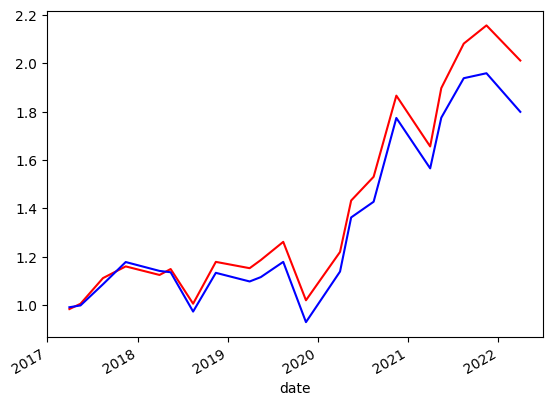

In [25]:
#from PIL import Image, ImageOps, ImageEnhance, __version__ as PILLOW_VERSION
#from pylab import rcParams


%matplotlib inline
returns = dataset_test['return'][prediction > 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='red')

returns = dataset_test['return'][prediction < 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='blue')

In [26]:
# from pylab import rcParams
